In [1]:
import numpy as np
import tensorflow as tf
import math
import os, time, itertools, pickle, random, glob, imageio
from PIL import Image
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# Load albumdata

img_size = 64
num_epoch =500
batch_size = 64
n_z = 64
z_val_name = 'z64_tras.npy'
z_list_name = 'z64_list.npy'


samples = np.load('vae/x_labels_64.npy')
samples = (1 - samples)
#samples = np.load('vae/x_samples_64.npy')
#labels = np.load('vae/x_labels_64.npy')

input_dim = img_size * img_size * 3
num_sample = samples.shape[0]

In [3]:
class VariantionalAutoencoder(object):

    def __init__(self, input_dim =input_dim, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z
        self.input_dim = input_dim

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession(config=tf.ConfigProto(
        allow_soft_placement=True,log_device_placement=True))
        self.sess.run(tf.global_variables_initializer())


    # Build the netowrk and the loss functions
    def build(self):
        
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, self.input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 2048, scope='enc_fc1', activation_fn=tf.nn.relu)
        print(f1)
        f2 = fc(f1, 1024, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 512, scope='enc_fc3', activation_fn=tf.nn.relu)
        f4 = fc(f3, 256, scope='enc_fc4', activation_fn=tf.nn.relu)
        f5 = fc(f4, 128, scope='enc_fc5', activation_fn=tf.nn.relu)
        f6 = fc(f5, 64, scope='enc_fc6', activation_fn=tf.nn.relu)
        self.z_mu = fc(f6, self.n_z, scope='enc_fc7_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f6, self.n_z, scope='enc_fc7_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        g4 = fc(g3, 1024, scope='dec_fc4', activation_fn=tf.nn.relu)
        g5 = fc(g4, 1024, scope='dec_fc5', activation_fn=tf.nn.relu)
        g6 = fc(g5, 2048, scope='dec_fc6', activation_fn=tf.nn.relu)
        self.x_hat = fc(g6, self.input_dim, scope='dec_fc7', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [4]:
def trainer_album(model_object, sample, input_dim =input_dim, learning_rate=1e-4, 
            batch_size=16, num_epoch=5, n_z=16, log_step=5,
                 num_sample = num_sample):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z,
    input_dim =input_dim)
    
    
    step = 0

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            step += 1
            # Get a batch
            batch = sample[iter * batch_size : (iter + 1) * batch_size]
            # Execute the forward and backward pass 
            # Report computed losses
            #print('batch',batch)
            losses = model.run_single_step(batch)
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [5]:
tf.reset_default_graph()

with tf.device('/gpu:0'):
    model_2d_vae = trainer_album(VariantionalAutoencoder, samples.reshape(-1,input_dim), 
                             num_epoch=num_epoch, batch_size=batch_size, n_z=n_z, 
                             input_dim =input_dim, num_sample=num_sample)

Tensor("enc_fc1/Relu:0", shape=(?, 2048), dtype=float32)
[Epoch 0] recon_loss: nan  latent_loss: nan  total_loss: nan  (19.216 sec/epoch)
[Epoch 5] recon_loss: nan  latent_loss: nan  total_loss: nan  (19.052 sec/epoch)
[Epoch 10] recon_loss: nan  latent_loss: nan  total_loss: nan  (19.080 sec/epoch)
[Epoch 15] recon_loss: nan  latent_loss: nan  total_loss: nan  (19.070 sec/epoch)
[Epoch 20] recon_loss: nan  latent_loss: nan  total_loss: nan  (19.056 sec/epoch)
[Epoch 25] recon_loss: nan  latent_loss: nan  total_loss: nan  (19.093 sec/epoch)
[Epoch 30] recon_loss: nan  latent_loss: nan  total_loss: nan  (18.919 sec/epoch)
[Epoch 35] recon_loss: nan  latent_loss: nan  total_loss: nan  (18.985 sec/epoch)
[Epoch 40] recon_loss: nan  latent_loss: nan  total_loss: nan  (19.006 sec/epoch)
[Epoch 45] recon_loss: nan  latent_loss: nan  total_loss: nan  (19.075 sec/epoch)
[Epoch 50] recon_loss: nan  latent_loss: nan  total_loss: nan  (19.046 sec/epoch)
[Epoch 55] recon_loss: nan  latent_loss: na

[Epoch 495] recon_loss: nan  latent_loss: nan  total_loss: nan  (18.857 sec/epoch)
Done!


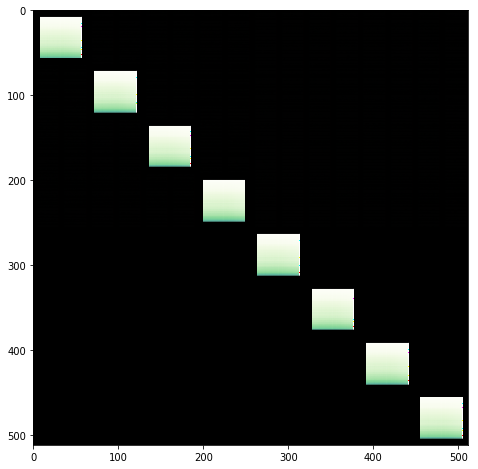

In [6]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model_2d_vae.batch_size, model_2d_vae.n_z])
x_generated = model_2d_vae.generator(z)

n = np.sqrt(model_2d_vae.batch_size).astype(np.int32)
I_generated = np.empty((img_size*n, img_size*n, 3))
#print(x_generated.shape)
for i in range(n):
    #print(i)
    I_generated[i*img_size:(i+1)*img_size, i*img_size:(i+1)*img_size, :
               ] = x_generated[i].reshape(img_size, img_size, 3)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated)

In [7]:
# get and save latent z
z_transform = model_2d_vae.transformer(samples.reshape(-1,img_size*img_size*3))
np.save(z_val_name, z_transform)

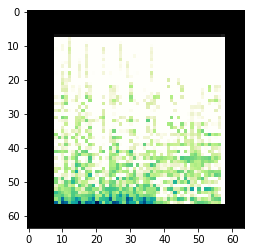

In [8]:
plt.imshow(samples[1])

In [9]:
x_hat = model_2d_vae.reconstructor(samples[1].reshape(-1, 64*64*3))

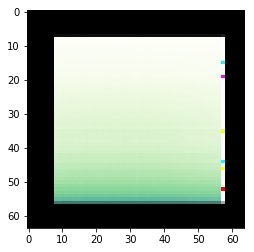

In [10]:
plt.imshow(x_hat.reshape(64,64,3))

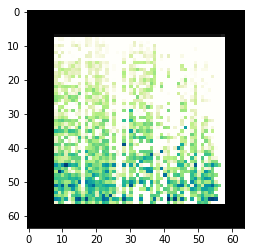

In [14]:
plt.imshow(samples[100])
plt.savefig('test1.png')

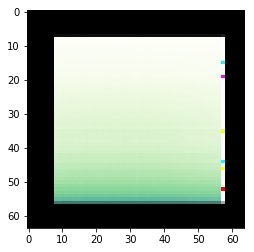

In [13]:
x_hat1 = model_2d_vae.reconstructor(samples[100].reshape(-1, 64*64*3))
plt.imshow(x_hat1.reshape(64,64,3))
plt.savefig('figure.png') 